In [1]:
import backtrader as bt
import matplotlib.pyplot as plt
import pandas as pd
import ccxt
%matplotlib widget

### Define Your Trading Strategy

Here, we define a simple moving average crossover strategy. This strategy implements a simple moving average (SMA) crossover strategy. This strategy generates a buy signal when a short-term SMA crosses above a long-term SMA and a sell signal (closing the position) when the short-term SMA crosses below the long-term SMA. The strategy was added to the Backtrader engine for testing.

In [2]:
class SmaCross(bt.Strategy):
    params = dict(
        pfast=10,  # period for the fast moving average
        pslow=30   # period for the slow moving average
    )

    def __init__(self):
        sma1 = bt.ind.SMA(period=self.p.pfast)
        sma2 = bt.ind.SMA(period=self.p.pslow)
        self.crossover = bt.ind.CrossOver(sma1, sma2)
        self.portfolio_values = []  # Initialize an empty list to store portfolio values

    def next(self):
        self.portfolio_values.append(self.broker.getvalue())  # Record current portfolio value
        if not self.position:
            if self.crossover > 0:
                self.buy()
        elif self.crossover < 0:
            self.close()

Load data into backtrader using CCXT

In [3]:
exchange = ccxt.binance({
    'rateLimit': 1200,
    'enableRateLimit': True,
})

symbol = 'ETH/USDT'
timeframe = '1d'  # 1-day candles
since = exchange.parse8601('2022-01-01T00:00:00Z')  # Fetch data since January 1, 2022
limit = 365  # Number of data points to fetch

ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit)

df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')  # Convert timestamps to datetime objects
df.set_index('timestamp', inplace=True)

data = bt.feeds.PandasData(dataname=df)

### Set Up and Run the Backtest

Configure the backtest, adding the strategy, data, and any other configurations like initial cash.

In [4]:
cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCross)
# Add data and set up broker etc., as before
cerebro.adddata(data)
cerebro.broker.setcash(10000.0)

strategies = cerebro.run()
first_strategy = strategies[0]
portfolio_values = first_strategy.portfolio_values

After the backtest completed, we manually plotted the recorded portfolio values over time using Matplotlib. This plot illustrates how the strategy's performance evolved throughout the backtesting period, showing the growth or decline of the portfolio value in response to the executed trades. The plot provides a visual summary of the strategy's effectiveness and can help identify periods of profitability or loss, contributing to a more nuanced evaluation of the strategy's viability in real-world trading scenarios.

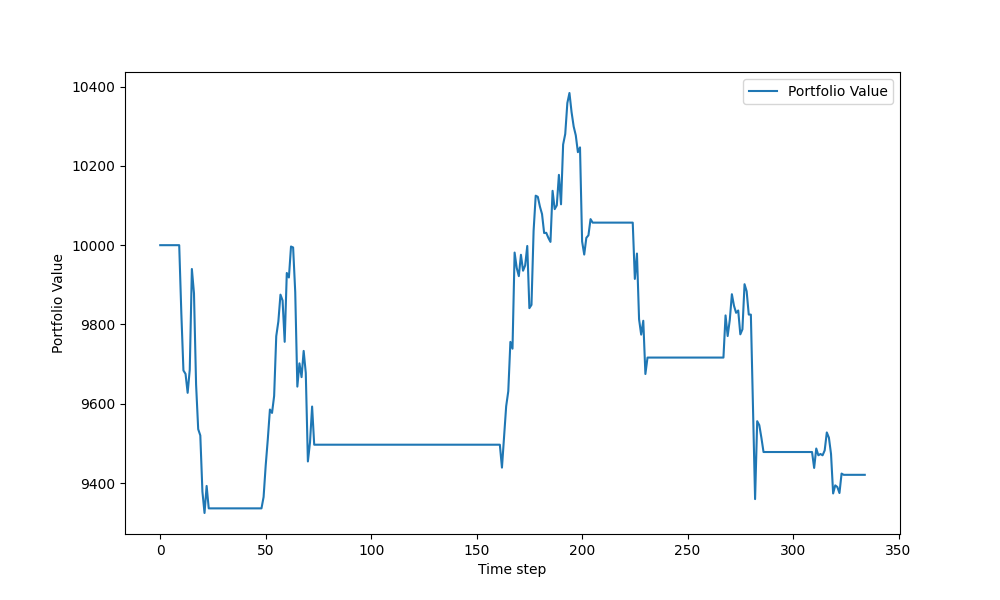

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(portfolio_values, label='Portfolio Value')
plt.xlabel('Time step')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()